In [249]:
!export PYTHONPATH=/home/luism/Workspace/fourier-HNN/

In [250]:
import torch
from experimentPendulum.trainFourierHNN import FourierHNN, MLP
from experimentPendulum.trainNaiveFourierHNN import NaiveFourierHNN, MLP
from experimentPendulum.trainHNN import HNN, MLP
from experimentPendulum.trainMLP import MLP
from DynamicSystemIntegrator import Integrator, ClassicHamiltonian
import autograd.numpy as np
from experimentPendulum.generateDataSets import get_trajectory
import matplotlib.pyplot as plt

import os

def getFourierHNNFromFile(): 
    scriptPath = os.path.abspath('experimentPendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    
    b_type = "Basic" # Basic Gaussian Positional
    if b_type == "Basic":
        B_Fourier = torch.eye(2)
    elif b_type == "Gaussian_10_1_":# Gaussian Fourier
        basicGaussianScale = 1
        B_out_dim = 10
        B_Fourier = torch.randn(2, B_out_dim) * basicGaussianScale
    elif b_type == "Positional":
        B_Fourier = torch.cat([torch.eye(2), 2*torch.eye(2), 3*torch.eye(2)], dim=1)

    forward_inputs = False
    learn_B = False

    learnString = "Learn" if learn_B else "DontLearn"
    forwardString = "ForwardInputs" if forward_inputs else "DontForwardInputs"
    label=f"{b_type}_{learnString}_{forwardString}"

    label = f'-FourierHNN-{label}'
    path = '{}/{}{}.tar'.format(dataSetFolder, "pendulum", label)
    
    fourierHNN = FourierHNN(2, 200, B_Fourier, learn_B, forward_inputs)
    fourierHNN.load_state_dict(torch.load(path, weights_only=True))
    fourierHNN.eval()
    return fourierHNN

def getNaiveFourierHNNFromFile(): 
    scriptPath = os.path.abspath('experimentPendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    label = '-NaiveFourierHNN'
    path = '{}/{}{}.tar'.format(dataSetFolder, "pendulum", label)
    
    nn_model = MLP(3, 200, 1, torch.tanh)
    naiveFourierHNN = NaiveFourierHNN(2, differentiable_model=nn_model)
    naiveFourierHNN.load_state_dict(torch.load(path, weights_only=True))
    naiveFourierHNN.eval()
    return naiveFourierHNN

def getHNNFile(): 
    scriptPath = os.path.abspath('experimentPendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    label = '-hnn'
    path = '{}/{}{}.tar'.format(dataSetFolder, "pendulum", label)
    
    nn_model = MLP(2, 200, 1, torch.tanh)
    hnn = HNN(2, differentiable_model=nn_model)
    hnn.load_state_dict(torch.load(path, weights_only=True))
    hnn.eval()
    return hnn

def getMLPFile(): 
    scriptPath = os.path.abspath('experimentPendulum')
    dataSetFolder = os.path.join(scriptPath, "Models")
    label = '-mlp'
    path = '{}/{}{}.tar'.format(dataSetFolder, "pendulum", label)
    
    model = MLP(2, 200, 2, torch.tanh)
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()
    return model


In [251]:
# Hamiltonian
def hamiltonian_fn(coords):
    q, p = np.split(coords,2)
    H = 3*(1-np.cos(q)) + p**2 # pendulum hamiltonian
    return H

hamiltonian = ClassicHamiltonian.Hamiltonian(1, hamiltonian_fn)

# Get trajectory
y0 = np.random.rand(2)*2.-1
radius = np.random.rand() + 1.3 
y0 = y0 / np.sqrt((y0**2).sum()) * radius

t_span = [0,30]
timescale = 100
# y0 = np.array([3,0.5])
# y0 = np.array([2,0])
y0 = np.array([3,0.05])

q, dq, d2q, p, dp, t_eval = get_trajectory(hamiltonian, t_span=t_span, timescale=timescale, y0=y0, noise_std=0)

energy = hamiltonian.getEnergy(np.concatenate([q,p]))

In [252]:
# Get MLP trajectory
mlp = getMLPFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1]]], dtype=torch.float32, requires_grad=True)
    dy = mlp.forward(y).detach()
    return np.array([dy[0][0], dy[0][1]])

t, mlp_y, mlp_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
mlp_q, mlp_p = np.split(mlp_y,2)
mlp_energy = hamiltonian_fn(np.concatenate([mlp_q, mlp_p]))


In [253]:
# Get HNN trajectory
hnn = getHNNFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1]]], dtype=torch.float32, requires_grad=True)
    dy = hnn.time_derivative(y).detach()
    return np.array([dy[0][0], dy[0][1]])

t, hnn_y, hnn_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
hnn_q, hnn_p = np.split(hnn_y,2)
hnn_energy = hamiltonian_fn(np.concatenate([hnn_q, hnn_p]))

In [254]:
# Get Naive Fourier trajectory
naiveFourierhnn = getNaiveFourierHNNFromFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1]]], dtype=torch.float32, requires_grad=True)
    dy = naiveFourierhnn.time_derivative(y).detach()
    return np.array([dy[0][0], dy[0][1]])

t, naive_fourier_hnn_y, naive_fourier_hnn_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
naive_fourier_hnn_q, naive_fourier_hnn_p = np.split(naive_fourier_hnn_y,2)
naive_fourier_hnn_energy = hamiltonian_fn(np.concatenate([naive_fourier_hnn_q, naive_fourier_hnn_p]))

In [255]:
# Get Fourier trajectory
fourierHNN = getFourierHNNFromFile()
def dynamics_fn(t, coords):
    y = torch.tensor([[coords[0], coords[1]]], dtype=torch.float32, requires_grad=True)
    dy = fourierHNN.time_derivative(y).detach()
    return np.array([dy[0][0], dy[0][1]])

t, fourier_hnn_y, fourier_hnn_dy = Integrator.integrateSystem(dynamics_fn, y0, t_eval)
fourier_hnn_q, fourier_hnn_p = np.split(fourier_hnn_y,2)
fourier_hnn_energy = hamiltonian_fn(np.concatenate([fourier_hnn_q, fourier_hnn_p]))

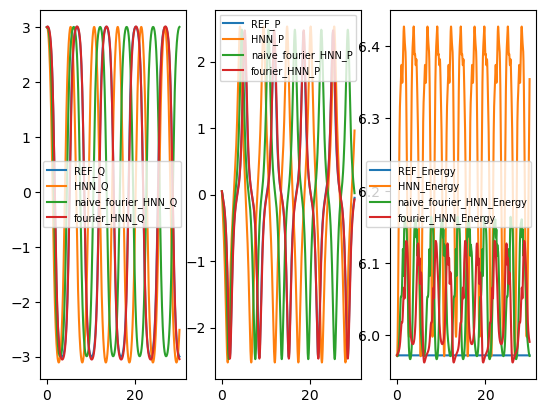

In [256]:
plt.subplot(1,3,1)
plt.plot(t, q[0], label=f'REF_Q')
# plt.plot(t, mlp_q[0], label=f'MLP_Q')
plt.plot(t, hnn_q[0], label=f'HNN_Q')
plt.plot(t, naive_fourier_hnn_q[0], label=f'naive_fourier_HNN_Q')
plt.plot(t, fourier_hnn_q[0], label=f'fourier_HNN_Q')
plt.legend(fontsize=7)

plt.subplot(1,3,2)
plt.plot(t, p[0], label=f'REF_P')
# plt.plot(t, mlp_p[0], label=f'MLP_P')
plt.plot(t, hnn_p[0], label=f'HNN_P')
plt.plot(t, naive_fourier_hnn_p[0], label=f'naive_fourier_HNN_P')
plt.plot(t, fourier_hnn_p[0], label=f'fourier_HNN_P')
plt.legend(fontsize=7)

plt.subplot(1,3,3)
plt.plot(t, energy[0], label=f'REF_Energy')
# plt.plot(t, mlp_energy[0], label=f'MLP_Energy')
plt.plot(t, hnn_energy[0], label=f'HNN_Energy')
plt.plot(t, naive_fourier_hnn_energy[0], label=f'naive_fourier_HNN_Energy')
plt.plot(t, fourier_hnn_energy[0], label=f'fourier_HNN_Energy')

plt.legend(fontsize=7)
plt.show()

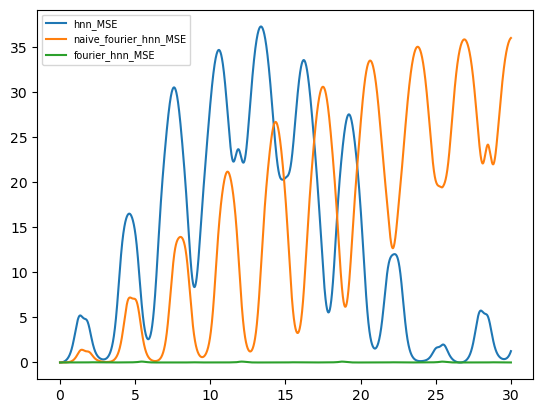

In [257]:
# MSE
mlp_MSE = (mlp_q - q)**2 + (mlp_p - p)**2
hnn_MSE = (hnn_q - q)**2 + (hnn_p - p)**2
naive_fourier_hnn_MSE = (naive_fourier_hnn_q - q)**2 + (naive_fourier_hnn_p - p)**2
fourier_hnn_MSE = (fourier_hnn_q - q)**2 + (fourier_hnn_p - p)**2

plt.subplot(1,1,1)
# plt.plot(t, mlp_MSE[0], label=f'mlp_MSE')
plt.plot(t, hnn_MSE[0], label=f'hnn_MSE')
plt.plot(t, naive_fourier_hnn_MSE[0], label=f'naive_fourier_hnn_MSE')
plt.plot(t, fourier_hnn_MSE[0], label=f'fourier_hnn_MSE')

plt.legend(fontsize=7)
plt.show()

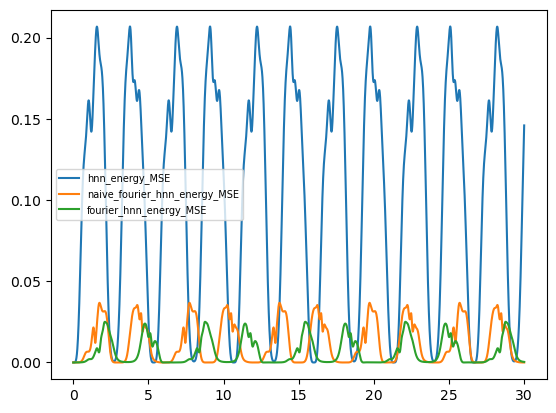

1942.3250616407881 312.784263608469 37.05238265864392 20.11572359116305


In [258]:
# Energy
mlp_energy_MSE = (mlp_energy - energy)**2
hnn_energy_MSE = (hnn_energy - energy)**2
naive_fourier_hnn_energy_MSE = (naive_fourier_hnn_energy - energy)**2
fourier_hnn_energy_MSE = (fourier_hnn_energy - energy)**2

plt.subplot(1,1,1)
# plt.plot(t, mlp_energy_MSE[0], label=f'mlp_energy_MSE')
plt.plot(t, hnn_energy_MSE[0], label=f'hnn_energy_MSE')
plt.plot(t, naive_fourier_hnn_energy_MSE[0], label=f'naive_fourier_hnn_energy_MSE')
plt.plot(t, fourier_hnn_energy_MSE[0], label=f'fourier_hnn_energy_MSE')

plt.legend(fontsize=7)
plt.show()
print(np.sum(mlp_energy_MSE), np.sum(hnn_energy_MSE), np.sum(naive_fourier_hnn_energy_MSE),np.sum(fourier_hnn_energy_MSE))

In [259]:
print(np.sum(mlp_MSE), np.sum(hnn_MSE),np.sum(naive_fourier_hnn_MSE),np.sum(fourier_hnn_MSE))
print(np.sum(mlp_energy_MSE), np.sum(hnn_energy_MSE),np.sum(naive_fourier_hnn_energy_MSE),np.sum(fourier_hnn_energy_MSE))

30021.864617866926 39278.70022527649 45588.697715849135 36.23250271423734
1942.3250616407881 312.784263608469 37.05238265864392 20.11572359116305
